# Bài Tập Lớn Cuối Kì Môn Học Máy
* MSSV : 18020271
* Tên : Hà Xuân Đăng

# Giới thiệu và mô tả bài toán
Xây dựng một thuật toán tự động đề xuất giá sản phẩm phù hợp khi đã được cung cấp các mô tả văn bản do người dùng nhập về sản phẩm của Mercari, bao gồm các chi tiết như tên danh mục sản phẩm, tên thương hiệu và tình trạng mặt hàng.

Input: Dữ liệu dạng text gồm **name**, **item_condition**, **category**, **brand_name**, **shipping** và **item_description** về sản phẩm.

Output: Giá của sản phẩm.

# Tổng quan về dữ liệu
**Tại đây ta sẽ phân tích và xem xét dữ liệu được cung cấp sau đó đưa ra phương pháp và xử lý dữ liệu**



### Khai báo các thư viện

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


### Giải nén các file nén dữ liệu

In [ ]:
!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/sample_submission.csv.7z
!unzip /kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
!unzip /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip

### Đọc dữ liệu từ bài toán vào dạng table sử dụng thư viện Pandas

In [ ]:
train_data = pd.read_table("train.tsv")
test_data = pd.read_table("test_stg2.tsv")

## Phân tích dữ liệu



    Đầu tiên kiểm tra thông tin của tập train và test.

In [ ]:
train_data.info()
test_data.info()

    Đưa ra số mẫu và số thuộc tính của từng dữ liệu

In [ ]:
print(train_data.shape)
print(test_data.shape)

**Nhận xét :**
* Tập train gồm 8 cột thông tin về sản phẩm và có tổng cộng 1482535 sản phẩm
* Tập test gồm 3460725 sản phẩm, có 7 cột thông tin và ta dự vào đó để tìm ra 'price' của sản phẩm

**Vì tập train là tập ta cần xử lý để huấn luyện nên ta phân tích tập train.**

    Ta xem xét các hàng đầu tiên của tập train

In [ ]:
train_data.head()

### Tổng quan về dữ liệu. 
Trong tập train ta có 8 trường thông tin dữ liệu: 
* train_id là chỉ số của sản phẩm 
* name id tên của sản phẩm (dạng text)
* item_condition_id là điều kiện của các mặt hàng này khi bán ra. (dạng số 1-5)
* category_name là danh mục của sản phẩm 
* brand_name là tên thương hiệu của sản phẩm 
* **price** là giá của sản phẩm và đây cũng là mục tiêu của bài toán này 
* shipping là sản phẩm này có được vận chuyển đến nhà (dạng số 0/1)
* item_description là mô tả thông tin sản phẩm (dạng văn bản)
> Do giá cả sản phẩm là mục tiêu của bài toán, nó là dạng dữ liệu số liên tục  
>> Bài toán này là dạng bài toán **Regression Linear Model**. 

https://excessive-source-1c9.notion.site/bfade10204144b5881938e965055035c?v=511e8c9338754d45b0eb9eb68e5bd5d8&p=f6ea06094fe8498d81279d685e100d5c

# Kiểm tra phân phối dữ liệu

**Price**

Kiểm tra phân phối của biến Price
* Ta loại bỏ các sản phẩm có price <= 0 
> Vì các sản phẩm giá <= 0 thì thường không có ý nghĩa cho mô hình

In [ ]:
train_data = train_data[train_data['price'] > 0].reset_index(drop = True)
# train, validation = train_test_split(train_data, test_size = 0.1, random_state = 30)
train = train_data.copy()
test = test_data.copy()
print(train.shape)
print(test.shape)

In [ ]:
train.price.describe().apply(lambda x: format(x, 'f'))

In [ ]:
unique_brands = train['brand_name'].value_counts()
print("Số nhãn hiệu phân biệt là {}".format(len(unique_brands)))
plt.figure(figsize=(20, 5))
sns.barplot(unique_brands.index[1:16], unique_brands[1:16])
plt.title('Top 15 các thương hiệu và số lượng sản phẩm của từng thương hiệu')
plt.xlabel('Tên thương hiệu')
plt.ylabel('Số lượng sản phẩm')
plt.show()

Nhận xét: 
* Nike và Victoria's Secret là 2 thương hiệu có số lượng sản phẩm đông nhất 
* Thương hiệu sản phẩm cũng một phần ảnh hưởng đến giá của sản phẩm đó

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(train['price'], bins=50, range=[0, 200], edgecolor='white')
plt.title('Phân phối của giá sản phẩm')
plt.xlabel('Price(Giá)')
plt.ylabel('Số sản phẩm')
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['price']), bins=50, edgecolor='white')
plt.title('Phân phối của log(Price)')
plt.xlabel('log(Price)')
plt.ylabel('Số sản phẩm')
plt.show()
# sns.displot(np.log1p(train['price']))

Ta thấy có vẻ như phân bố của biến Price lệch, biểu đồ hóa biến Price để kiểm tra

In [ ]:
sns.distplot(train['price'])

Phân bố lệch về bên trái. Ta sử dụng hàm đồng biến log() sẽ đưa đồ thị giá về gần dạng phân bố chuẩn.

In [ ]:
train['price'] = np.log1p(train['price'])
sns.distplot(train['price'])

**Item_condition_id**

Kiểm tra danh sách giá trị biến item_condition_id

In [ ]:
train['item_condition_id'].value_counts()

In [ ]:
count = train['item_condition_id'].value_counts()
plt.figure(figsize=(15, 5))
sns.barplot(count.index[:5], count[:5])
plt.ylabel('Số lượng sản phẩm')
plt.xlabel('Điều kiện sản phẩm')

**Shipping**

In [ ]:
train['shipping'].value_counts()

In [ ]:
count = train['shipping'].value_counts()
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
sns.barplot(count.index, count)
plt.xlabel('Shipping')
plt.ylabel('Số sản phẩm')
plt.subplot(1, 2, 2)
labels = ['Không Ship', 'Có Ship']
sizes = count
colors = ['blue', 'orange']
explode = (0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

Nhận xét: 
* Phần lớn các sản phẩm đều được trả tiền vận chuyển bởi người mua. 
* Số lượng mặt hàng không shipping chiếm 55% và 45% còn lại được shipping

**Item_description**

Kiểm tra phân phối biến item_description

In [ ]:
train['item_description'].value_counts().head()

**Brand_name**

Kiểm tra danh sách giá trị biến brand_name

In [ ]:
train['brand_name'].value_counts().head()

**Category**

Kiểm tra số lượng giá trị category khác nhau trên tập train :

In [ ]:
print(train['category_name'].nunique())

Xem xét 10 giá trị đầu của category

In [ ]:
train['category_name'].value_counts().head(10)

In [ ]:
train['category_name'].isnull().sum()

Nhận thấy các giá trị trong cột category tạo nên từ 3 category riêng

Có 6314 giá trị null cho cột category

==> Từ 2 nhận xét trên ta đề xuất tách category thành 3 cột **main_cat**,**sub_cat** và **item_cat** và chuẩn hóa giá trị **null** để dễ phân tích

# Xử lý dữ liệu
## Làm sạch dữ liệu
**Xử lý cột Category_name**

In [ ]:
def category_split(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Missing', 'Missing', 'Missing']
train['main_cat'], train['sub_cat'], train['item_cat'] = zip(*train['category_name'].apply(lambda x: category_split(x)))
test['main_cat'], test['sub_cat'], test['item_cat'] = zip(*test['category_name'].apply(lambda x: category_split(x)))

**Xử lý dữ liệu chứa giá trị null**

Thay thế giá trị null thành giá trị Missing trên 3 cột: **category**, **brand** và **item_description**

In [ ]:
def fill(data):
    data['category_name'].fillna('Missing', inplace = True)
    data['brand_name'].fillna('Missing', inplace = True)
    data['item_description'].fillna('Missing', inplace = True)
    return data

fill(train)
fill(test)

**Kiểm tra lại dữ liệu đã làm sạch qua các bước đã qua trên tập train :**

In [ ]:
train.head()

In [ ]:
train.nunique()

Như ta thấy số loại giá trị trên dữ liệu của **name** và **item_description** lớn hơn hẳn các columns khác nên:

**==> Vectơ hóa name và item_description**

**==> Phân loại theo label các features còn lại**

## Vectơ hóa dữ liệu

In [ ]:
# Quy đổi thời gian 
import time
def format_time(seconds):
    days = int(seconds / 3600 / 24)
    seconds = seconds - days * 3600 * 24
    hours = int(seconds / 3600)
    seconds = seconds - hours * 3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes * 60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds * 1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

**Vectơ hóa Name column**

Để thực hiện vectơ hóa cột name ta dùng mô hình BoW (Bag-of-words)

Mô hình bag-of-words là một mô hình đơn giản hóa được sử dụng trong xử lý ngôn ngữ tự nhiên và truy xuất thông tin (IR). Trong mô hình này, một văn bản (chẳng hạn như một câu hoặc một tài liệu) được biểu thị như một túi (nhiều tập hợp) các từ của nó, không tính đến ngữ pháp và thậm chí cả trật tự từ nhưng vẫn giữ tính đa nghĩa

Tham khảo : https://en.wikipedia.org/wiki/Bag-of-words_model

In [ ]:
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
start_time = time.time()
cnt_vec = CountVectorizer()

X_train_name = cnt_vec.fit_transform(train['name'])
X_test_name = cnt_vec.transform(test['name'])
print('Name Completed: {}'.format(format_time(time.time() - start_time)))
print(X_train_name.shape)
print(X_test_name.shape)

**Vectơ hóa Item_Description Column**

Để thực hiện vectơ hóa cột name ta dùng mô hình TF-IDF(Term Frequency – Inverse Document Frequency)

TF-IDF là 1 kĩ thuật sử dụng trong khai phá dữ liệu văn bản. Trọng số này được sử dụng để đánh giá tầm quan trọng của một từ trong một văn bản. Giá trị cao thể hiện độ quan trọng cao và nó phụ thuộc vào số lần từ xuất hiện trong văn bản nhưng bù lại bởi tần suất của từ đó trong tập dữ liệu

Tham khảo : https://vi.wikipedia.org/wiki/Tf%E2%80%93idf

In [ ]:
start_time = time.time()
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), stop_words='english')

X_train_descp = tfidf_descp.fit_transform(train['item_description'])
X_test_descp = tfidf_descp.transform(test['item_description'])
print('Item Description Completed: {}'.format(format_time(time.time() - start_time)))

In [ ]:
train.head()

**Phân loại các features còn lại thông qua LabelBinarizer**

LabelBinarizer là một thuật toán phân loại hồi quy và nhị phân có sẵn trong scikit. Nó giúp ta phân loại dữ liệu theo các label theo kiểu one-vs-all

Tham khảo : https://www.kite.com/python/docs/sklearn.preprocessing.LabelBinarizer

In [ ]:
from sklearn.preprocessing import LabelBinarizer

Tại đây ta sẽ áp dụng labelBinarizer trên tất cả các biến còn lại trên tập dữ liệu huấn luyện và kiểm tra.

In [ ]:
start_time = time.time()

lb_brand_name = LabelBinarizer(sparse_output=True)
X_train_brand = lb_brand_name.fit_transform(train['brand_name'])
X_test_brand = lb_brand_name.transform(test['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_train_item_condition_id = lb_item_cond_id.fit_transform(train['item_condition_id'])
X_test_item_condition_id = lb_item_cond_id.transform(test['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output=True)
X_train_shipping = lb_shipping.fit_transform(train['shipping'])
X_test_shipping = lb_shipping.transform(test['shipping'])

print('Complete in: {}'.format(format_time(time.time() - start_time)))

In [ ]:
start_time = time.time()

lb_main_cat = LabelBinarizer(sparse_output=True)
X_train_main_cat = lb_main_cat.fit_transform(train['main_cat'])
X_test_main_cat = lb_main_cat.transform(test['main_cat'])

lb_sub_cat = LabelBinarizer(sparse_output=True)
X_train_sub_cat = lb_sub_cat.fit_transform(train['sub_cat'])
X_test_sub_cat = lb_sub_cat.transform(test['sub_cat'])

lb_item_cat = LabelBinarizer(sparse_output=True)
X_train_item_cat = lb_item_cat.fit_transform(train['item_cat'])
X_test_item_cat = lb_item_cat.transform(test['item_cat'])

print('Complete in: {}'.format(format_time(time.time() - start_time)))

In [ ]:
# Full dataframe printing
print(type(X_train_brand), type(X_train_item_condition_id), type(X_train_shipping))
print(type(X_test_brand), type(X_test_item_condition_id), type(X_test_shipping))

In [ ]:
# Train dataframe printing
print('X_train_brand shape:', X_train_brand.shape)
print('X_train_item_cond_id shape:', X_train_item_condition_id.shape)
print('X_train_shipping shape:', X_train_shipping.shape)
print('X_train_main_cat shape:', X_train_main_cat.shape)
print('X_train_sub_cat shape:', X_train_sub_cat.shape)
print('X_train_item_cat shape:', X_train_item_cat.shape)

**==> Gán nhãn hoàn thành trên tập train**

In [ ]:
# Test dataframe printing
print('X_test_brand shape:', X_test_brand.shape)
print('X_test_item_cond_id shape:', X_test_item_condition_id.shape)
print('X_test_shipping shape:', X_test_shipping.shape)
print('X_test_main_cat shape:', X_test_main_cat.shape)
print('X_test_sub_cat shape:', X_test_sub_cat.shape)
print('X_test_item_cat shape:', X_test_item_cat.shape)

**==> Gán nhãn hoàn thành trên tập test**

## Xếp chồng X_train

Xếp chồng các khối dữ liệu đã xử lý thành ma trận X_train

In [ ]:
from scipy.sparse import hstack
import gc

In [ ]:
sparse_matrix_list = (X_train_name, X_train_descp, X_train_brand, 
                      X_train_item_condition_id, X_train_shipping, 
                      X_train_main_cat, X_train_sub_cat, X_train_item_cat)

Chuyển đổi ma trận này thành dạng dạng hàng được nén để sử dụng

In [ ]:
X_train = hstack(sparse_matrix_list).tocsr()
print(type(X_train), X_train.shape)

In [ ]:
del X_train
gc.collect()

# Xây Dựng Các Mô Hình Học Máy Và Huấn Luyện Dữ Liệu

Hàm evaluate có dạng như sau:

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_orig_price(y_test, preds):
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    return rmsle(y_test_exmpm, preds_exmpm)

Gói các features phục vụ quá trình training và testing.

Để đánh giá độ hiệu quả của model,
### Tách dữ liệu tập train ra thàn tập train và validation 
* Giữ lại 80% tập train là tâp dữ liệu huấn liệu
* Dùng 20% tập train là tập validation
> Dùng tập validation là tập dữ liệu không được huấn luyện để kiểm tra chất lượng của mô hình.
>> Phần này có thể giúp ta cho việc hyparameter tuning

In [ ]:
def model_train_predict(model, matrix_list):
    X = hstack(matrix_list).tocsr()
    X_train, X_test, y_train, y_test = train_test_split(X, train['price'], test_size=0.2)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    del X, X_train, X_test, y_train
    gc.collect()
    
    return preds, y_test

**Ridge Regression Model**

Regression Ridge là một cách để tạo mô hình phân tích khi số lượng biến dự báo trong một tập hợp vượt quá số lượng quan sát hoặc khi tập dữ liệu có đa cộng tuyến (tương quan giữa các biến dự báo)

Ridge Regression về cơ bản cũng giống với Linear Regression truyền thống, vẫn sử dụng đến hàm mean square error nhưng có điểm khác là công thức tìm giá trị hệ số w thì bổ sung thêm ràng buộc để sao cho các hệ số w nhỏ nhất có thể đến mức gần bằng 0, nghĩa là các feature (x) ít có ảnh hưởng tới giá trị đầu ra. Ràng buộc này sử dụng công thức chuẩn hóa L2.

https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.872.1902&rep=rep1&type=pdf

In [ ]:
start_time = time.time()
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (X_train_name, X_train_brand, 
                      X_train_item_condition_id, X_train_shipping, 
                      X_train_main_cat, X_train_sub_cat, X_train_item_cat)

linear_preds, y_test = model_train_predict(model=linear_model, 
                                           matrix_list=sparse_matrix_list)

print('Item Description rmsle:', evaluate_orig_price(y_test, linear_preds))

sparse_matrix_list = (X_train_name, X_train_descp, X_train_brand, 
                      X_train_item_condition_id, X_train_shipping, 
                      X_train_main_cat, X_train_sub_cat, X_train_item_cat)


linear_preds, y_test = model_train_predict(model=linear_model, 
                                           matrix_list=sparse_matrix_list)
print('Item Description rmsle:', evaluate_orig_price(y_test, linear_preds))

print('Complete in: {}'.format(format_time(time.time() - start_time)))

*** Kết quả ***

In [ ]:
sparse_matrix_list = (X_train_name, X_train_descp, X_train_brand, 
                      X_train_item_condition_id, X_train_shipping, 
                      X_train_main_cat, X_train_sub_cat, X_train_item_cat)

X_train = hstack(sparse_matrix_list).tocsr()
X_train

In [ ]:
sparse_matrix_list = (X_test_name, X_test_descp, X_test_brand, 
                      X_test_item_condition_id, X_test_shipping, 
                      X_test_main_cat, X_test_sub_cat, X_test_item_cat)
X_test = hstack(sparse_matrix_list).tocsr()

In [ ]:
y_train = train['price']
y_train

In [ ]:
linear_model.fit(X_train, y_train)

In [ ]:
preds = linear_model.predict(X_test)
preds

In [ ]:
preds = np.expm1(preds)
preds

**Lasso Regression**

Một mô hình anh em với Ridge là Laso, thay vì Ridge sử dụng công thức chuẩn hóa L2 khi tìm hệ số w thì Laso sử dụng công thức chuẩn hóa L1. Sử dụng công thức chuẩn hóa L1 nhằm mục đích loại bớt feature ít ảnh hưởng tới đầu ra nghĩa là làm cho phần lớn các trọng số w = 0.

https://cs.nyu.edu/~roweis/csc2515-2006/readings/lasso.pdf

In [ ]:
sparse_matrix_list = (X_train_name, X_train_descp, X_train_brand, 
                      X_train_item_condition_id, X_train_shipping, 
                      X_train_main_cat, X_train_sub_cat, X_train_item_cat)

train_X = hstack(sparse_matrix_list).tocsr()
train_Y = train_data["price"]
X_train, X_validation, y_train, y_validation = train_test_split(train_X, train_Y, test_size=0.1, random_state=42)
def evaluation(model):
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_validation)
    train_score = rmsle(np.expm1(train_pred), y_train)
    validation_score = rmsle(np.expm1(val_pred), y_validation)
    print("Evaluation ---- Training Dataset Score: {}, Validation Dataset Score: {}".format(train_score, validation_score))
    return train_score, validation_score

def train(model):
    X, y = X_train, np.log1p(y_train)
    model.fit(X, y)
    evaluation(model)
    return model

In [ ]:
lasso_model = Lasso(alpha=1e-06, fit_intercept=False)
lasso_model = train(lasso_model)

**LightGBM**

LightGBM viết tắt của Light Gradient Boosting Machine, là mã nguồn mở xử lý thuật toán tăng cường độ dốc (Gradient Boosting) được phát triển bởi Microsoft. Gradient Boosting là một thuật toán xuất phát từ thuật toán Cây quyết định (Decision Tree), nó thực hiện việc xây dựng tuần tự nhiều Cây quyết định và tiến hành học tập. 

https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf

In [ ]:
import lightgbm as lgb
params = {
    'learning_rate': 0.75,
    'application': 'regression',
    'max_depth': 3,
    'num_leaves': 100,
    'verbosity': -1,
    'metric': 'RMSE',
}
d_train = lgb.Dataset(X_train, label=np.log1p(y_train))
d_valid = lgb.Dataset(X_validation, label=np.log1p(y_validation))
watchlist = [d_train, d_valid]

lgbm_model = lgb.train(
    params, 
    train_set=d_train, 
    num_boost_round=2200, 
    valid_sets=watchlist, 
    early_stopping_rounds=50, 
    verbose_eval=100
)

### So sánh kết quả của 3 mô hình

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Train RMSLE", "Validation RMSLE"]
table.add_row(["Ridge Regression", 0.497253, 0.464687])
table.add_row(["Lasso Regression", 0.439915, 0.456478])
table.add_row(["LightGBM", 0.438928, 0.45633])
print(table)

### Nhận xét: 
* Các mô hình học máy Ridge Regression, Lasso Regression, LightGBM cũng không có nhiều sự khác biệt trên tập validation 
* Vì vậy các mô hình học máy không có tính chất ảnh hưởng nhiều đến kết quả bài toán, mà kết quả phần lớn bị ảnh hưởng nhất bởi phần trích xuất đặc trưng tạo ra vector đặc trưng cho từng sản phẩm. 
* Ngoài ra, ta cũng có thể áp dụng các kĩ thuật tìm kiếm để tìm kiếm bộ tham số tốt nhất cho các mô hình học máy

# Chuẩn bị Submission 

In [ ]:
submission: pd.DataFrame = test[['test_id']]
submission['price'] = preds
submission.to_csv("submission.csv", index=False)

In [ ]:
submission.head()

# Kết quả

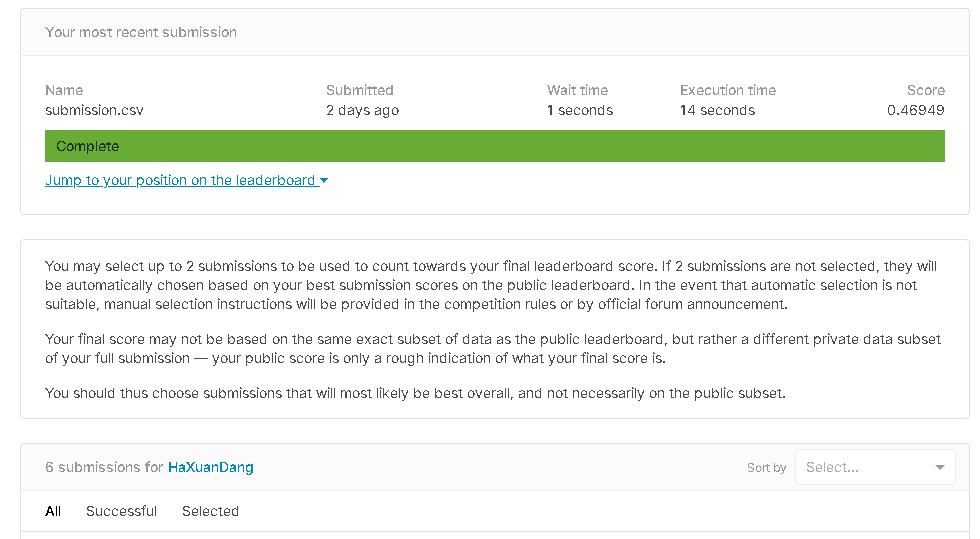